# <center> <u>Trabajo Práctico final</u> </center>
# <u>Materia:</u> Análisis de Datos Científicos y Geográficos
# <u>Profesor:</u> Rodrigo Ramele
# <u>Estudiantes:</u> Kazimierski, Martín; Krysa, Ariel
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;

# Importación de librerías/paquetes y de la base de datos

Comenzamos el trabajo con la importación de una serie de paquetes, cuyas principales funcionalidades utilizadas se describen a continuación:
- **pandas**: para bases de datos (y con metadata);
- **numpy**: para operaciones de Machine Learning;
- **matplotlib**: para graficos en general;
- **seaborn**: para gráficos más elaborados;
- **stringIO**: para consumir APIs desde la Web;
- **time**: para medir tiempos de procesamiento;
- **scipy**: para generación de estadísticas y filtrado de la señal;
- **sklearn**: para generar variables categoricas/dummies y normalizar las señales filtradas; división de la muestra; generación, fiteo y evaluación de modelos.

In [69]:
# Importamos algunas librerias que vamos a necesitar
# coding: latin-1
import pandas as pd #empleado particularmente para bases de datos (y con metadata)
import numpy as np #utilizado especialmente para operaciones de Machine Learning
import matplotlib.pyplot as plt #Para graficos
from io import StringIO #Para consumir APIs desde la Web
from time import time #Para medir tiempos de procesamiento

import csv
import math
import scipy
from scipy import stats
from scipy.signal import butter, filtfilt, detrend
import seaborn as sns #Sirve para algunos graficos
import warnings #Para descartar warnings referidos a updates

from sklearn.preprocessing import LabelEncoder, StandardScaler #Para generar variables categoricas/dummies y normalizar las señales filtradas
from sklearn.model_selection import train_test_split # Para division de la muestra entre train y test
from sklearn.linear_model import LogisticRegression #Para regresion lineal
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier # Para arboles de decision
from sklearn.svm import SVC #Para Support Vector Machines
from sklearn.ensemble import RandomForestClassifier #Para Random Forest
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #Para Linear Discriminant Analysis
from sklearn.neural_network import MLPClassifier #Para Redes Neuronales
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc # Para evaluacion de pronosticos
from sklearn.metrics import plot_roc_curve #Gráficos de curvas ROC

Luego, accedemos a los principales dos insumos de datos para el trabajo: una base de datos "eeg.dat" y un video. Ambos se encuentran en https://drive.google.com/file/d/1ByQDK4ZPxbqw7T17k--avTcgSCCzs3vi/view?usp=sharing.
Los descargamos del Drive y los cargamos en un repositorio github, desde el cual lo leeremos cada vez que corramos el codigo. 
La base de datos "eeg.dat" contiene los potenciales eléctricos de una persona, que es grabada en el video mencioando. La frecuencia de sampleo es de 128 Hertz

In [70]:
# Accedemos a la base de datos
url = "https://raw.githubusercontent.com/kryari/python-scientific/master/TP/eeg.dat"
signals = pd.read_csv(url, delimiter=' ', names = ['timestamp','counter','eeg','attention','meditation','blinking'] ) #Signals es ahora un dataframe con una estructura de pandas::

# Utilizamos los valores de eeg como tensor de numpy (matriz numerica).
data = signals.values #Quitamos la metadata y nos quedamos con los valores numericos
#print (data)
eeg = data[:,2] #Nos quedamos con todas las filas y solo la segunda columna (la de counter)

# Estructura, características y limpieza de la base de datos

## La base de datos

Comenzamos el estudio de la base de datos observando sus dimensiones y variables.

In [71]:
print("Dimension de la matriz: {}".format(data.shape)) #Vemos que el archivo total tiene 339301 filas y 6 columnas
print('Longitud del archivo (filas):'+str(len(data)))

Dimension de la matriz: (339301, 6)
Longitud del archivo (filas):339301


In [72]:
print('Estructura de la informacion del archivo como dataset:')
print(signals.head()) #Vemos primeras filas del archivo para ver como esta estructurado

Estructura de la informacion del archivo como dataset:
      timestamp  counter  eeg  attention  meditation  blinking
0  1.655925e+09       68   32          0           0         0
1  1.655925e+09       69   40          0           0         0
2  1.655925e+09       70   42          0           0         0
3  1.655925e+09       71   34          0           0         0
4  1.655925e+09       72   24          0           0         0


De acuerdo a la salida anterior, la base de datos contiene las siguientes variables:
1. **timestamp**: timestamp "comun".
2. **counter**: contador para tener en cuenta las tramas que se recibe del sensor wireless. Sirve para detectar si se perdió alguna trama (dentro de las 128 seguidas). Va creciendo de 0 a 99 y después vuelve a 0. Con el timestamp, que lo introduce la computadora, no se puede hacer.
3. **eeg**: variable de potenciales electricos de la persona (eeg). Por la descomposición espectral se puede dividir entre attention y meditation.
4. **attention**: inversa de la potencia en 10hz de la señal. Si la potencia en 10Hz aumenta, el valor de attention es más bajo.
5. **meditation**: potencia en 4hz de la señal. La columna meditación es para medir las señales delta de muy baja frecuencia que aumentan cuando uno sueña algo.
6. **blinking**: indica pestaneo. No es operativa (toma el valor de 0 en todas las observaciones).

Seguidamente, buscamos la presencia de valores missing (NaN), para eventualmente corregirlos. Este paso no fue necesario ya que la base de datos no contenía este tipo de valores.

In [73]:
# Calculamos la cantidad de valores NA para ver si hay que trabajar sobre ellos
data_NA = np.isnan(data)
n_NA = np.sum(data_NA)
print("La base de datos tiene", n_NA, "valores faltantes (NaN).")

La base de datos tiene 0 valores faltantes (NaN).


En la siguiente tabla presentamos un resumen de estadísticas descriptivas de las variables que componen la base de datos:

In [74]:
# Breves estadisticas descriptivas/estructura de la base de datos:
#print('Algunas estadisticas descriptivas de las variables')
signals.describe()

,timestamp,counter,eeg,attention,meditation,blinking
count,3.393010e+05,339301.000000,339301.000000,339301.000000,339301.000000,339301.0
mean,1.655925e+09,49.501127,31.001577,64.062720,41.658757,0.0
std,1.905190e+02,28.867526,90.962463,21.247321,17.424993,0.0
min,1.655925e+09,0.000000,-1628.000000,0.000000,0.000000,0.0
25%,1.655925e+09,24.000000,3.000000,47.000000,29.000000,0.0
50%,1.655925e+09,50.000000,33.000000,64.000000,41.000000,0.0
75%,1.655925e+09,75.000000,60.000000,81.000000,53.000000,0.0
max,1.655925e+09,99.000000,1380.000000,100.000000,100.000000,0.0


A partir de la salida de signals.describe(), podemos sacar algunas conclusiones sobre las diferentes columnas del conjunto de datos. En primer lugar, la columna *eeg* representa la señal EEG medida durante la sesión y será nuestro foco de atención durante el trabajo. La variable *attention* representa el nivel de atención del sujeto durante la sesión. El valor medio es 64.06, y la desviación estándar es 21.25. El valor mínimo es 0 y el valor máximo es 100, lo que sugiere que el nivel de atención varió ampliamente durante la sesión. Por su parte, la variable *meditation* representa el nivel de meditación del sujeto durante la sesión. El valor medio es 41.66, y la desviación estándar es 17.42. El valor mínimo es 0 y el valor máximo es 100, lo que sugiere que el nivel de meditación también varió ampliamente durante la sesión.

## Estadísticas de la variable de interés

Una de las variables centrales de nuestro ejercicio es la serie temporal "EEG". La utilizaremos particularmente para predecir los estados en el que se encuentra la persona.
En el siguiente gráfico presentamos el electrocardiograma completo, que cuenta con 339301 observaciones:

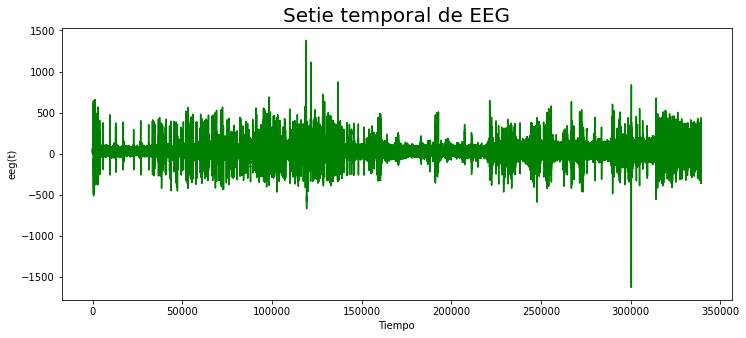

In [7]:
#Armamos plot del electrocardiograma completo

#t = np.linspace(-0.02, 0.05, 1000)
#plt.plot(t, 325 * np.sin(2*np.pi*50*t));
plt.figure(figsize=(12,5))
plt.plot(eeg,'r', label='EEG',color="green")
plt.xlabel("Tiempo",size=10); #defino label x para el grafico
plt.ylabel('eeg(t)'); #defino label y para el grafico
#plt.title(r'Plot of CT signal $x(t)=325 \sin(2\pi 50 t)$');
plt.title(r'Setie temporal de EEG',size=20)
#plt.ylim([-2000, 2000]);
#plt.xlim([0,len(eeg)])
#print('Este es el plot del electrocardiograma completo (339301 observaciones):')
plt.show()

In [8]:
#Ponemos el eje en la serie EEG:
print("Algunas métricas del vector EEG: \n")
print("Cantidad de tramas: {}".format(len(eeg)))
print("Max valor: {}".format(eeg.max()))
print("Min valor: {}".format(eeg.min()))
print("Rango: {}".format(eeg.max()-eeg.min()))
print("Valor promedio: {}".format(eeg.mean()))
print("Varianza: {}".format(eeg.var()))
print("Std: {}".format(math.sqrt(eeg.var())))

Algunas métricas del vector EEG: 

Cantidad de tramas: 339301
Max valor: 1380.0
Min valor: -1628.0
Rango: 3008.0
Valor promedio: 31.001576771067576
Varianza: 8274.145269705741
Std: 90.96232884939644


De acuerdo con la salida anterior, el valor medio de EEG es 31.00, y la desviación estándar es 90.96. El valor mínimo es -1628 y el valor máximo es 1380, lo que sugiere que puede haber algunos valores atípicos o extremos en esta columna. Además, estos resultados sugieren que la señal EEG en este conjunto de datos es altamente variable y puede contener valores atípicos y ruido. Esto puede requerir un preprocesamiento cuidadoso antes de realizar un análisis detallado de la señal.

A continuación, generamos una serie de visualizaciones (gráficos de histograma, boxplot y Q-norm) para tener una primera noción de la distribución de la variable de señal: 

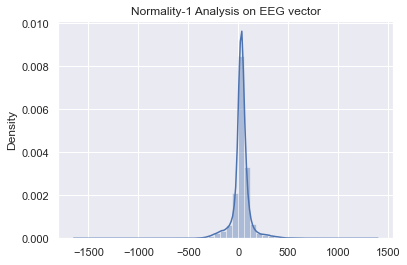

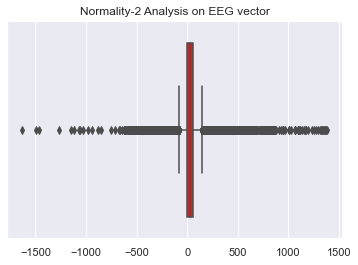

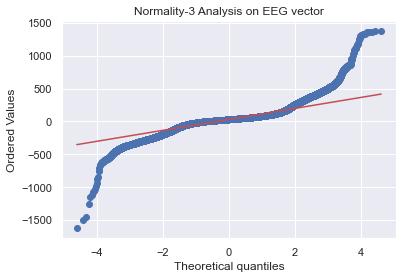

In [68]:
# Prueba de normalidad
import scipy
from scipy import stats

warnings.filterwarnings("ignore")

sns.distplot(eeg)
plt.title("Normality-1 Analysis on EEG vector")
plt.show()
sns.boxplot(eeg,color="red")
plt.title("Normality-2 Analysis on EEG vector")
plt.show()
res = stats.probplot(eeg, plot = plt)
plt.title("Normality-3 Analysis on EEG vector") 
plt.show()

En el **histograma** vemos que la serie tiene forma de normal pero extremadamente estirada (se registra muy poca densidad en los valores centrales, así como muchos valores posibles).
Por otro lado, del **boxplot** se desprende la existencia de valores centrales muy cercanos al primer y tercer cuartil (caja pequeña), así como una gran cantidad de valores atipicos (numerosa cantidad de círculos por fuera de la caja), mientras que el grafico **Q-Normal** sugiere una distribución empírica apreciablemente distanciada de sus valores teoricos (la curva azul se muestra apreciablemente separada respecto a la línea recta roja).
Para una mayor rigurosidad en la hipótesis de normalidad, se procedió a realizar un test de normalidad (basado en D'Agostino y Person (1971); y D'Agostino y Person (1973)), que considera como hipótesis nula que la muestra proviene de una distribución normal:

In [10]:
print('normality = {}'.format(scipy.stats.normaltest(eeg)))

normality = NormaltestResult(statistic=72637.37129791787, pvalue=0.0)


Como se observa en la salida anterior, se rechaza la hipotesis nula de normalidad de la distribución de los eeg (el test da un pvalue de 0.0). La ausencia de normalidad nos lleva a dejar a un lado ciertos modelos que requieren ese supuesto como base para el estudio de la serie, como podrían ser los ARIMA. \
A continuación creamos gráficos de la señal distinguiendo por valor de atención y meditación a lo largo del tiempo:

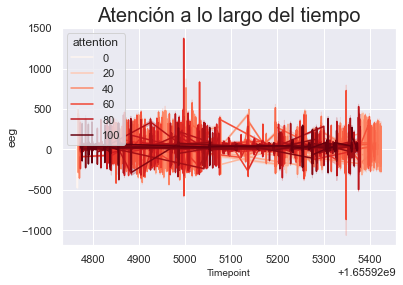

Tiempo que tarda en graficar los datos: 284.06 s


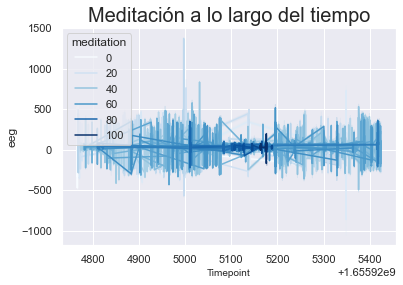

Tiempo que tarda en graficar los datos: 278.87 s


In [12]:
# Gráfico con valores de atención
t0 = time()
sns.set(style="darkgrid")
sns.lineplot(x="timestamp", y="eeg", hue="attention", data=signals, palette="Reds")
plt.title("Atención a lo largo del tiempo", size=20)
plt.xlabel("Timepoint", size=10)
plt.show()
t1 = time()
print('Tiempo que tarda en graficar los datos: {} s'.format(round(t1-t0,2)))

# Gráfico con valores de meditación
t0 = time()
sns.lineplot(x="timestamp", y="eeg", hue="meditation", data=signals, palette="Blues")
plt.title("Meditación a lo largo del tiempo", size=20)
plt.xlabel("Timepoint", size=10)
plt.show()
t1 = time()
print('Tiempo que tarda en graficar los datos: {} s'.format(round(t1-t0,2)))

## Creación de la variable temporal

En lo que sigue, creamos y trabajamos con una nueva variable temporal, que permita mayor precisión respecto al timestamp y el conteo (counter), y que sea consistente con el tiempo reportado en el video.

In [14]:
# Agregamos una nueva columna llamada "tiempo" que se use para "traducir" el timestamp
from datetime import datetime
signals['timestamp'].min() #Miramos el minimo valor
tiempo=datetime.fromtimestamp(signals.loc[1].iat[0]) #generamos una variable tiempo con una unica observacion
print(tiempo)

2022-06-22 16:06:04.970000


In [15]:
#Agregamos una nueva columna (variable) de tiempo al dataset 'signals'
signals['tiempo']=pd.to_datetime(signals['timestamp'], unit='s')
signals.head() 

,timestamp,counter,eeg,attention,meditation,blinking,tiempo
0,1.655925e+09,68,32,0,0,0,2022-06-22 19:06:04.970000029
1,1.655925e+09,69,40,0,0,0,2022-06-22 19:06:04.970000029
2,1.655925e+09,70,42,0,0,0,2022-06-22 19:06:04.970000029
3,1.655925e+09,71,34,0,0,0,2022-06-22 19:06:04.970000029
4,1.655925e+09,72,24,0,0,0,2022-06-22 19:06:04.970000029


Encontramos que la variable "tiempo" registra una diferencia con el registrado el video, que arranca en el tiempo 2022-06-22 20:05. Es por ello que procedemos a calcular la distancia temporal entre ambas fuentes, de forma tal de corregir nuestra nueva variable creada.

In [16]:
#Calculamos la diferencia entre tiempo identificado en el video y el timestamp.
from datetime import datetime, timedelta

diferencia =  pd.to_datetime('2022-06-22 20:05.5662') -  pd.to_datetime('2022-06-22 19:06:04.97') #observamos que la diferencia es de 59 min.
diferencia

Timedelta('0 days 00:59:28.030000')

En la siguiente tabla presentamos la base de datos incorporando la nueva variable temporal corregida (*tiempo*).

In [18]:
# Corregimos la variable "tiempo" de la base de datos para que sea consistente con el video
signals['tiempo'] = signals['tiempo'] + timedelta(minutes=59, seconds=28) #sumamos el tiempo especificado a la variable "tiempo"
signals.head()

,timestamp,counter,eeg,attention,meditation,blinking,tiempo
0,1.655925e+09,68,32,0,0,0,2022-06-22 20:05:32.970000029
1,1.655925e+09,69,40,0,0,0,2022-06-22 20:05:32.970000029
2,1.655925e+09,70,42,0,0,0,2022-06-22 20:05:32.970000029
3,1.655925e+09,71,34,0,0,0,2022-06-22 20:05:32.970000029
4,1.655925e+09,72,24,0,0,0,2022-06-22 20:05:32.970000029


## Generación de categorías relacionadas con el estado de la persona

Una vez que que contamos con una variable "tiempo" relacionable con el video, observamos deteminademente éste último y clasificamos clasificamos cada segmento de la señal de acuerdo a lo que consideramos que está realizando el sujeto.\
Cabe aclarar que entre el período 20:09:19 y 20:10:15 detectamos varios intervalos de "sonreir" y "respirarapido"; no obstante, para ser lo más parsimoniosos posible, identificamos a todo el intervalo como "respirarapido" (ver sentencias comentadas en el comando siguiente).

In [19]:
label=['baseline','tos','respirahondo','respirarapido','cuentamental','violeta','rojo','sonreir','desagradable','agradable','pestaneoscodigo']

signals.loc[(signals.tiempo >= '2022-06-22 20:05:32.97') & (signals.tiempo < '2022-06-22 20:06:06'),'label']='baseline'
signals.loc[(signals.tiempo >= '2022-06-22 20:06:06') & (signals.tiempo < '2022-06-22 20:06:09'),'label']='pestaneoscodigo'
signals.loc[(signals.tiempo >= '2022-06-22 20:06:09') & (signals.tiempo < '2022-06-22 20:07:11'),'label']='baseline'
signals.loc[(signals.tiempo >= '2022-06-22 20:07:11') & (signals.tiempo < '2022-06-22 20:07:12'),'label']='pestaneoscodigo'
signals.loc[(signals.tiempo >= '2022-06-22 20:07:12') & (signals.tiempo < '2022-06-22 20:07:15'),'label']='baseline'
signals.loc[(signals.tiempo >= '2022-06-22 20:07:15') & (signals.tiempo < '2022-06-22 20:08:15'),'label']='tos'
signals.loc[(signals.tiempo >= '2022-06-22 20:08:15') & (signals.tiempo < '2022-06-22 20:08:19'),'label']='pestaneoscodigo'
signals.loc[(signals.tiempo >= '2022-06-22 20:08:19') & (signals.tiempo < '2022-06-22 20:08:36'),'label']='respirahondo'
signals.loc[(signals.tiempo >= '2022-06-22 20:08:36') & (signals.tiempo < '2022-06-22 20:08:40'),'label']='sonreir'
signals.loc[(signals.tiempo >= '2022-06-22 20:08:40') & (signals.tiempo < '2022-06-22 20:09:16'),'label']='respirahondo'
signals.loc[(signals.tiempo >= '2022-06-22 20:09:16') & (signals.tiempo < '2022-06-22 20:09:19'),'label']='pestaneoscodigo'

#signals.loc[(signals.tiempo >= '2022-06-22 20:09:19') & (signals.tiempo < '2022-06-22 20:09:40'),'label']='respirarapido'
#signals.loc[(signals.tiempo >= '2022-06-22 20:09:40') & (signals.tiempo < '2022-06-22 20:09:42'),'label']='sonreir'
#signals.loc[(signals.tiempo >= '2022-06-22 20:09:42') & (signals.tiempo < '2022-06-22 20:09:58'),'label']='respirarapido'
#signals.loc[(signals.tiempo >= '2022-06-22 20:09:58') & (signals.tiempo < '2022-06-22 20:10:04'),'label']='sonreir'
#signals.loc[(signals.tiempo >= '2022-06-22 20:10:04') & (signals.tiempo < '2022-06-22 20:10:15'),'label']='respirarapido'
signals.loc[(signals.tiempo >= '2022-06-22 20:09:19') & (signals.tiempo < '2022-06-22 20:10:15'),'label']='respirarapido'

signals.loc[(signals.tiempo >= '2022-06-22 20:10:15') & (signals.tiempo < '2022-06-22 20:10:17'),'label']='pestaneoscodigo'
signals.loc[(signals.tiempo >= '2022-06-22 20:10:17') & (signals.tiempo < '2022-06-22 20:11:15'),'label']='cuentamental'
signals.loc[(signals.tiempo >= '2022-06-22 20:11:15') & (signals.tiempo < '2022-06-22 20:11:18'),'label']='pestaneoscodigo'
signals.loc[(signals.tiempo >= '2022-06-22 20:11:18') & (signals.tiempo < '2022-06-22 20:12:17'),'label']='violeta'
signals.loc[(signals.tiempo >= '2022-06-22 20:12:17') & (signals.tiempo < '2022-06-22 20:12:21'),'label']='pestaneoscodigo'
signals.loc[(signals.tiempo >= '2022-06-22 20:12:21') & (signals.tiempo < '2022-06-22 20:13:16'),'label']='rojo'
signals.loc[(signals.tiempo >= '2022-06-22 20:13:16') & (signals.tiempo < '2022-06-22 20:14:18'),'label']='sonreir'
signals.loc[(signals.tiempo >= '2022-06-22 20:14:18') & (signals.tiempo < '2022-06-22 20:14:22'),'label']='pestaneoscodigo'
signals.loc[(signals.tiempo >= '2022-06-22 20:14:22') & (signals.tiempo < '2022-06-22 20:14:41'),'label']='desagradable'
signals.loc[(signals.tiempo >= '2022-06-22 20:14:41') & (signals.tiempo < '2022-06-22 20:16:15'),'label']='agradable'
signals.loc[(signals.tiempo >= '2022-06-22 20:16:15') & (signals.tiempo < '2022-06-22 20:17:06'),'label']='pestaneoscodigo'

signals.head()

,timestamp,counter,eeg,attention,meditation,blinking,tiempo,label
0,1.655925e+09,68,32,0,0,0,2022-06-22 20:05:32.970000029,baseline
1,1.655925e+09,69,40,0,0,0,2022-06-22 20:05:32.970000029,baseline
2,1.655925e+09,70,42,0,0,0,2022-06-22 20:05:32.970000029,baseline
3,1.655925e+09,71,34,0,0,0,2022-06-22 20:05:32.970000029,baseline
4,1.655925e+09,72,24,0,0,0,2022-06-22 20:05:32.970000029,baseline


Para delimitar algunas características de cada categoría, graficamos nuevamente la señal, ahora distinguiendo los distintos intervalos y acciones del sujeto.

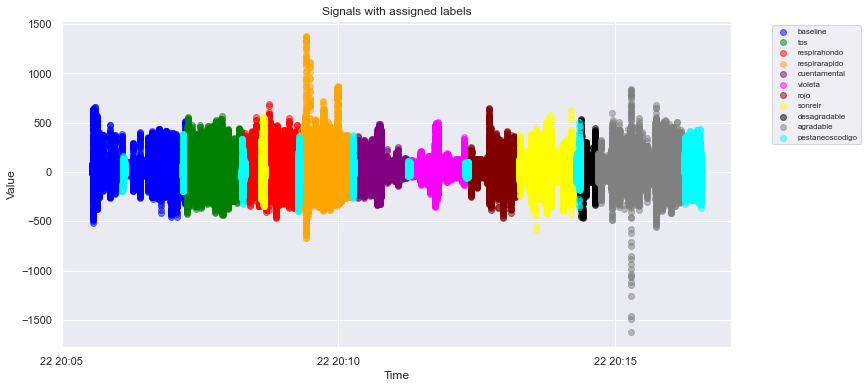

In [20]:
cmap = {'baseline': 'blue', 'tos': 'green', 'respirahondo': 'red', 'respirarapido': 'orange', 'cuentamental': 'purple', 'violeta': 'magenta', 'rojo': 'maroon', 'sonreir': 'yellow', 'desagradable': 'black', 'agradable': 'gray', 'pestaneoscodigo': 'cyan'}

plt.figure(figsize=(12, 6))
for label in cmap:
    plt.scatter(signals[signals['label']==label]['tiempo'], signals[signals['label']==label]['eeg'], c=cmap[label], alpha=0.5, label=label)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals with assigned labels')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=8)
plt.show()

Del gráfico anterior destaca la heterogeneidad de los valores adoptados por la señal durante los distintos estados, los cuales tienen una duración (ancho en el gráfico) en mayor o menor medida similar. Llama también la atención la altura de los picos alcanzados en el "estado respirarapido" (coloreado en naranja), así como el rango mucho más acotado que en el caso de "cuenta mental", "violeta" y "rojo" respecto a baseline.
A continuación graficamos brevemente las dos categorías que posteriormente serán de interés: "baseline" y "respirarapido".

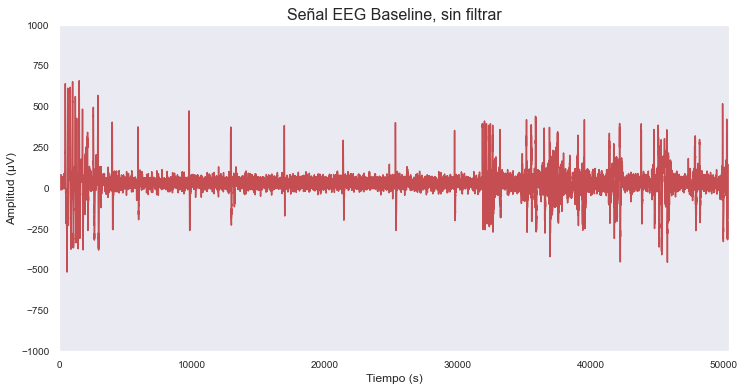

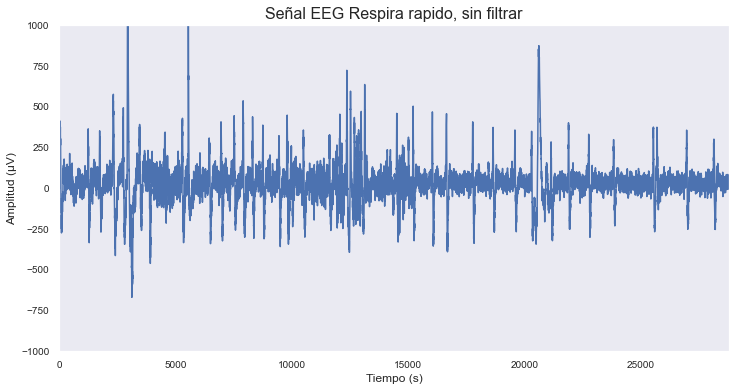

In [21]:
label = ['baseline', 'respirarapido']
baseline_resprapido = signals.query('label in @label')
baseline_resprapido

baseline = baseline_resprapido[baseline_resprapido['label'] == 'baseline']
baseline_data = baseline.values
baseline_eeg = baseline_data[:,2]

plt.figure(figsize=(12, 6))
plt.plot(baseline_eeg, 'r', label='Señal EEG')
plt.xlabel('Tiempo (s)', fontsize=12);
plt.ylabel('Amplitud (µV)', fontsize=12);
plt.title('Señal EEG Baseline, sin filtrar', fontsize=16)
plt.ylim([-1000, 1000]);
plt.xlim([0, len(baseline_eeg)])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

resprapido = baseline_resprapido[baseline_resprapido['label'] == 'respirarapido']
resprapido_data = resprapido.values
resprapido_eeg = resprapido_data[:,2]

plt.figure(figsize=(12, 6))
plt.plot(resprapido_eeg, 'b', label='Señal EEG')
plt.xlabel('Tiempo (s)', fontsize=12);
plt.ylabel('Amplitud (µV)', fontsize=12);
plt.title('Señal EEG Respira rapido, sin filtrar', fontsize=16)
plt.ylim([-1000, 1000]);
plt.xlim([0, len(resprapido_eeg)])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

Como se observa en los gráficos anteriores, al respirar rapido se alcanzan valores de eeg con mayor amplitud (superando en algunos casos el valor de 700) y volatilidad. En particular, surgen picos y valles locales mucho más repetitivos que en el caso base. Para ver estas cuestiones con mayor precisión, generamos algunas estadísticas descriptivas correspondientes.

In [22]:
print("Estadísticas descriptivas de Baseline:\n")

print("Dimension de la matriz: {}".format(baseline.shape))
print("Cantidad de tramas: {}".format(len(baseline_eeg)))
print("Max valor: {}".format(baseline_eeg.max()))
print("Min valor: {}".format(baseline_eeg.min()))
print("Rango: {}".format(baseline_eeg.max()-baseline_eeg.min()))
print("Valor promedio: {}".format(baseline_eeg.mean()))
print("Varianza: {}".format(baseline_eeg.var()))
print("Std: {}".format(math.sqrt(baseline_eeg.var())))

Estadísticas descriptivas de Baseline:

Dimension de la matriz: (50399, 8)
Cantidad de tramas: 50399
Max valor: 659
Min valor: -514
Rango: 1173
Valor promedio: 30.892398658703545
Varianza: 6284.535952656306
Std: 79.27506513813978


In [23]:
print("Estadísticas descriptivas de Respira rapido:\n")

print("Dimension de la matriz: {}".format(resprapido.shape))
print("EEG Vector Metrics\n")
print("Cantidad de tramas: {}".format(len(resprapido_eeg)))
print("Max valor: {}".format(resprapido_eeg.max()))
print("Min valor: {}".format(resprapido_eeg.min()))
print("Rango: {}".format(resprapido_eeg.max()-resprapido_eeg.min()))
print("Valor promedio: {}".format(resprapido_eeg.mean()))
print("Varianza: {}".format(resprapido_eeg.var()))
print("Std: {}".format(math.sqrt(resprapido_eeg.var())))

Estadísticas descriptivas de Respira rapido:

Dimension de la matriz: (28788, 8)
EEG Vector Metrics

Cantidad de tramas: 28788
Max valor: 1380
Min valor: -669
Rango: 2049
Valor promedio: 31.131026816729193
Varianza: 16294.43892478958
Std: 127.64967263878737


Como se observa en las dos salidas anteriores, en la comparación entre el baseline y respira rapido, se destaca que:\
    - Hay mayor cantidad de observaciones de baseline;\
    - Respira rapido tiene valores máximos más altos y valores mínimos más bajos;\
    - Como resultado del item anterior, el rango es más amplio en el caso de la respiración rápida;\
    - La varianza de respira rápido más que duplica la de baseline, corroborando las intuiciones previamente señaladas.

## Filtrado y generación de features

Con el objetivo de mejorar la clasificación de la señal, aplicamos una limpieza a través de la función **detrend**, y luego generamos nuevas características basadas en el análisis de la frecuencia, utilizando filtros espectrales que permiten filtrar información en el dominio espectral, y eliminar el ruido contenido en la señal. Dentro del conjunto de opciones, que incluyen los denominados low-pass, **band-pass** y high-pass, tuvimos en consideración los segundos, y nos enfocamos en las bandas theta, alfa, beta y gamma.\
La banda theta contiene el rango de frecuencias de 4 a 8Hz. La banda alfa se vincula con el rango de frecuencias de 8 a 13Hz y se asocia a estados de relajación y meditación. En tanto, la banda beta (entre 13 y 30Hz) es un rango de frecuencias que suele relacionarse con la atención y la concentración.
Una vez realizada la descomposición en frecuencias, normalizamos las series obtenidas al restar la media y dividirlo por el desvío.

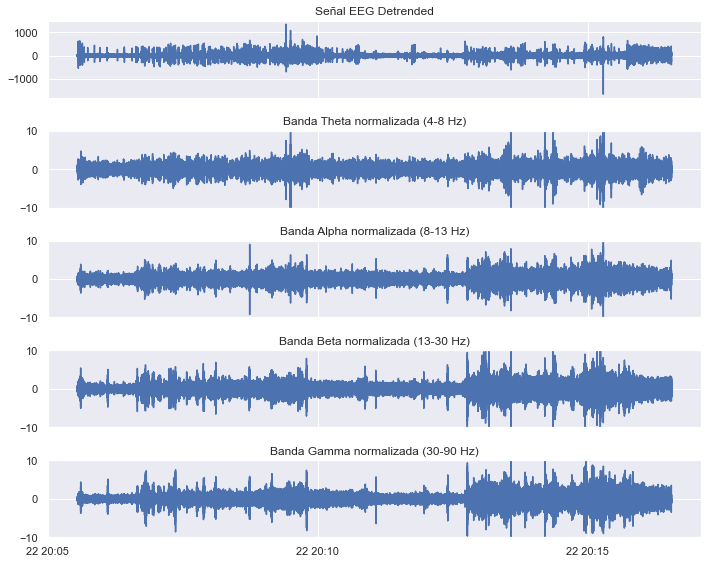

In [24]:
from scipy.signal import butter, filtfilt, detrend

#signals.loc[:,'eeg'] = detrend(signals['eeg'])

# Bandas de Frecuencia
Fs = 128
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


# Aplicamos los filtros detrend y bandpass a la señal EEG
Fs = 128
signals['eeg_detrended'] = detrend(signals['eeg'])
signals['eeg_theta'] = butter_bandpass_filter(signals['eeg_detrended'], 4, 8, Fs)
signals['eeg_alpha'] = butter_bandpass_filter(signals['eeg_detrended'], 8, 13, Fs)
signals['eeg_beta'] = butter_bandpass_filter(signals['eeg_detrended'], 13, 30, Fs)
signals['eeg_gamma'] = butter_bandpass_filter(signals['eeg_detrended'], 30, 50, Fs)

#Tomamos media y desvio estandar de las series filtradas.
signals['eeg_mean'] = signals.groupby(['tiempo'])['eeg'].transform('mean')
signals['eeg_std'] = signals.groupby(['tiempo'])['eeg'].transform('std')
signals['eeg_detrended_mean'] = signals.groupby(['tiempo'])['eeg_detrended'].transform('mean')
signals['eeg_detrended_std'] = signals.groupby(['tiempo'])['eeg_detrended'].transform('std')
signals['eeg_theta_mean'] = signals.groupby(['tiempo'])['eeg_theta'].transform('mean')
signals['eeg_theta_std'] = signals.groupby(['tiempo'])['eeg_theta'].transform('std')
signals['eeg_alpha_mean'] = signals.groupby(['tiempo'])['eeg_alpha'].transform('mean')
signals['eeg_alpha_std'] = signals.groupby(['tiempo'])['eeg_alpha'].transform('std')
signals['eeg_beta_mean'] = signals.groupby(['tiempo'])['eeg_beta'].transform('mean')
signals['eeg_beta_std'] = signals.groupby(['tiempo'])['eeg_beta'].transform('std')
signals['eeg_gamma_mean'] = signals.groupby(['tiempo'])['eeg_gamma'].transform('mean')
signals['eeg_gamma_std'] = signals.groupby(['tiempo'])['eeg_gamma'].transform('std')

#Creamos nuevas series en base a normalizacion (utilizando StandardScaler)
scaler = StandardScaler()
signals[['eeg_normalized', 'eeg_detrended_normalized','eeg_theta_normalized', 'eeg_alpha_normalized', 'eeg_beta_normalized', 'eeg_gamma_normalized']] = scaler.fit_transform(signals[['eeg', 'eeg_detrended', 'eeg_theta', 'eeg_alpha', 'eeg_beta', 'eeg_gamma']])

#Eliminamos valores NA e infinitos (tanto negativos como positivos)
signals = signals.replace([np.inf, -np.inf], np.nan)
signals = signals.dropna()

fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 8))
ax[0].plot(signals['tiempo'], signals['eeg_detrended'])
ax[0].set_title('Señal EEG Detrended')
#ax[0].set_ylim([-10, 10])
ax[1].plot(signals['tiempo'], signals['eeg_theta_normalized'])
ax[1].set_title('Banda Theta normalizada (4-8 Hz)')
ax[1].set_ylim([-10, 10])
ax[2].plot(signals['tiempo'], signals['eeg_alpha_normalized'])
ax[2].set_title('Banda Alpha normalizada (8-13 Hz)')
ax[2].set_ylim([-10, 10])
ax[3].plot(signals['tiempo'], signals['eeg_beta_normalized'])
ax[3].set_ylim([-10, 10])
ax[3].set_title('Banda Beta normalizada (13-30 Hz)')
ax[4].plot(signals['tiempo'], signals['eeg_gamma_normalized'])
ax[4].set_ylim([-10, 10])
ax[4].set_title('Banda Gamma normalizada (30-90 Hz)')

plt.tight_layout()
plt.show()

Tras aplicar la función detrend(), podemos ver que la señal es ahora mucho más suave y parece tener una línea de base más estable. Esto ayuda a la identificación de las actividades EEG de interés. \
En cuanto a la descomposición en bandas, podemos ver que la banda theta es la más estable y con una menor cantidad de picos (sólo registrables hacia el final de la serie). Por otro lado, especialmente en torno al momento 20:08 (cuando se genera "respirarapido") y a partir del tiempo 20:15 (coincidiendo con estados de "agradable", "desagradable" y "pestaneocodigo"), hay periodos de potencia alfa relativamente alta intercalados con otros de baja potencia. Esto sugeriría que Rodrigo pasó durante ese intervalo desde estados de relajación a otros de alerta, y viceversa. \
Finalmente, las potencias beta y gamma son relativamente similares, con diversos picos durante la sesión. Es indicaría que la persona podría haber estado bastante concentrado en alguna tarea en particular durante la grabación.

# Ejercicio de detección de parpadeo a partir de umbrales

A continuación, implementamos un enfoque para detectar parpadeos en una señal de EEG utilizando **umbrales dinámicos establecidos por percentiles**. Los umbrales se establecen en el 1er y 99º percentil de la señal, lo que significa que el 98% de los datos se consideran dentro de los límites de control. Luego, creamos un filtro de parpadeo utilizando estos límites y encontramos los picos positivos y negativos en la señal. Finalmente, identificamos los picos y valles que corresponden a los momentos de pestañeo y se cuentan la cantidad de pestañeos y su ubicación.

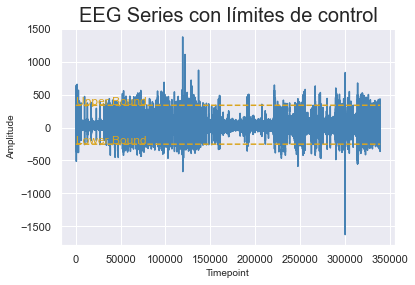

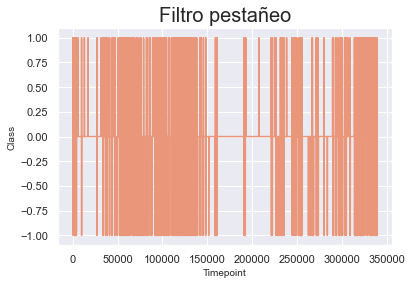

Conteo de pestañeos: 1602
Ubicación de pestañeo
[   461    465    576 ... 339190 339196 339201]


In [25]:
# Establecer dinámicamente los umbrales de detección de parpadeo utilizando percentiles.
lowerbound, upperbound = np.percentile(eeg, [1, 99])

# Crear un gráfico de los valores EEG con los límites de control
plt.plot(eeg, color="steelblue")
plt.plot(np.full(len(eeg), lowerbound), color="goldenrod", ls="--")
plt.plot(np.full(len(eeg), upperbound), color="goldenrod", ls="--")
plt.ylim([min(eeg)*1.1, max(eeg)*1.1 ])
plt.annotate("Lower Bound", xy=(500, lowerbound+10), color="goldenrod")
plt.annotate("Upper Bound", xy=(500, upperbound+10), color="goldenrod")
plt.title("EEG Series con límites de control", size=20)
plt.xlabel("Timepoint", size=10)
plt.ylabel("Amplitude", size=10)
plt.show()

# Creamos un filtro de parpadeo basado en los valores umbral
blinks = np.where(eeg > upperbound, 1, np.where(eeg < lowerbound, -1, 0))

# Creamos un gráfico del filtro parpadeante
plt.plot(blinks, color="darksalmon")
plt.title("Filtro pestañeo", size=20)
plt.xlabel("Timepoint", size=10)
plt.ylabel("Class", size=10)
plt.show()

# Encontramos los picos positivos y negativos (momentos de pestañeo) en la señal de eeg
from scipy.signal import find_peaks
peaks, _ = find_peaks(eeg, height=upperbound)
valleys, _ = find_peaks(-eeg, height=-lowerbound)

# Seleccionamos solo los picos y valles que corresponden a momentos de pestañeo
blinks_peaks = np.intersect1d(peaks, np.where(blinks == 1))
blinks_valleys = np.intersect1d(valleys, np.where(blinks == -1))

# Concatenamos los picos y valles y ordenamos por tiempo
blinklocations = np.sort(np.concatenate([blinks_peaks, blinks_valleys]))

# Contamos la cantidad de pestañeos y mostrar su ubicación
blinkcount = len(blinklocations)
print(f'Conteo de pestañeos: {blinkcount}')
print('Ubicación de pestañeo');print(blinklocations)

Este enfoque puede ser útil para la detección de parpadeos en la señal de EEG en tiempo real y en situaciones en las que no se dispone de un modelo de aprendizaje automático o no se desea utilizar uno. Además, establecer los umbrales dinámicamente mediante percentiles permite que los límites de control se adapten a las variaciones en la señal a lo largo del tiempo, lo que puede mejorar la precisión de la detección de parpadeos. Sin embargo, este enfoque puede no funcionar bien en situaciones en las que la señal de EEG tiene un componente no despreciable de ruido o en la que los patrones de parpadeo son muy irregulares.

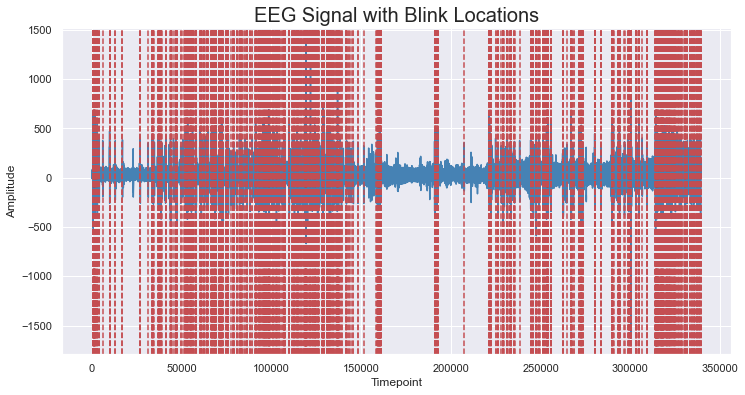

In [26]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(eeg, color="steelblue")
ax.set_ylim([min(eeg)*1.1, max(eeg)*1.1])
ax.set_title("EEG Signal with Blink Locations", size=20)
ax.set_xlabel("Timepoint", size=12)
ax.set_ylabel("Amplitude", size=12)

for loc in blinklocations:
    ax.axvline(loc, color='r', linestyle='--')
    
plt.show()

El gráfico anterior nos permite visualizar los parpadeos en el contexto de la señal EEG global. Podemos ver que los parpadeos detectados corresponden a caídas y subidas repentinas de la amplitud de la señal. Asimismo, nos brinda la posibilidad de identificar posibles falsos positivos o falsos negativos en la detección de parpadeos. Por ejemplo, si vemos una línea roja que no corresponde a un parpadeo real, esto podría indicar que el umbral utilizado para detectar parpadeos es demasiado sensible. Del mismo modo, si observamos un parpadeo en la señal de EEG que no está marcado con una línea roja, esto podría indicar que el umbral no es lo suficientemente sensible. En general, este gráfico puede ayudarnos a afinar el algoritmo de detección de parpadeos y mejorar su precisión. En lo que sigue, visualizamos su contraste con el label "pestaneoscodigo".

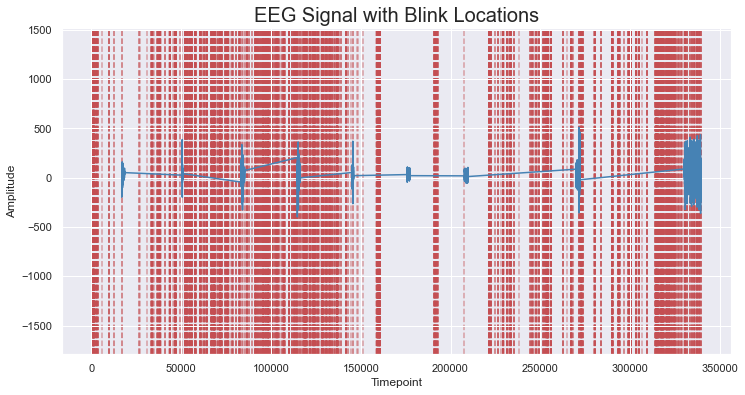

In [27]:
label = ['pestaneoscodigo']
pestaneoscodigo = signals.query('label in @label')
pestaneoscodigo_eeg = pestaneoscodigo['eeg']

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(pestaneoscodigo_eeg, color="steelblue")
ax.set_ylim([min(eeg)*1.1, max(eeg)*1.1])
ax.set_title("EEG Signal with Blink Locations", size=20)
ax.set_xlabel("Timepoint", size=12)
ax.set_ylabel("Amplitude", size=12)

for loc in blinklocations:
    ax.axvline(loc, color='r', alpha=0.5, linestyle='--', zorder=0)

plt.show()

Se observa cierto solapamiento entre la intensidad de los pestañeos detectados y el período de pestaneoscodigo del sujeto. Dado que no todos los pesteñeos del sujeto fueron reportados con su label durante la visualización del video, el gráfico anterior también da cuenta de esta limitación, motivo por el cual este procesamiento preliminar realizado debe ser ajustado.

# Series filtradas a utilizar en la generación de modelos

A continuación, generamos una base de datos que contenga sólo nuestras categorías de interés (baseline y respirarapido) para proceder a la generación de gráficos, implementación de modelos y evaluación de los mismos.

In [28]:
label = ['baseline', 'respirarapido']
baseline_resprapido = signals.query('label in @label')
baseline_resprapido

,timestamp,counter,eeg,attention,meditation,blinking,tiempo,label,eeg_detrended,eeg_theta,...,eeg_beta_mean,eeg_beta_std,eeg_gamma_mean,eeg_gamma_std,eeg_normalized,eeg_detrended_normalized,eeg_theta_normalized,eeg_alpha_normalized,eeg_beta_normalized,eeg_gamma_normalized
0,1.655925e+09,68,32,0,0,0,2022-06-22 20:05:32.970000029,baseline,1.057287,-0.698592,...,0.946055,5.163186,-0.216125,1.418114,0.010976,0.011623,-0.044965,0.030131,-0.003769,-0.001547
1,1.655925e+09,69,40,0,0,0,2022-06-22 20:05:32.970000029,baseline,9.057287,0.487574,...,0.946055,5.163186,-0.216125,1.418114,0.098925,0.099572,0.031372,0.050099,0.414873,-0.322636
2,1.655925e+09,70,42,0,0,0,2022-06-22 20:05:32.970000029,baseline,11.057287,1.470577,...,0.946055,5.163186,-0.216125,1.418114,0.120912,0.121559,0.094635,0.077050,0.358008,0.181859
3,1.655925e+09,71,34,0,0,0,2022-06-22 20:05:32.970000029,baseline,3.057286,2.021812,...,0.946055,5.163186,-0.216125,1.418114,0.032963,0.033610,0.130110,0.119890,-0.067892,0.207497
4,1.655925e+09,72,24,0,0,0,2022-06-22 20:05:32.970000029,baseline,-6.942714,1.983307,...,0.946055,5.163186,-0.216125,1.418114,-0.076972,-0.076325,0.127632,0.177767,-0.344794,-0.215176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144992,1.655925e+09,92,28,54,51,0,2022-06-22 20:10:14.980000019,respirarapido,-2.993021,-9.162413,...,-0.708693,15.566863,-0.045218,2.723681,-0.032998,-0.032904,-0.589664,0.289173,0.254981,-0.039539
144993,1.655925e+09,93,17,54,51,0,2022-06-22 20:10:14.980000019,respirarapido,-13.993021,-5.993747,...,-0.708693,15.566863,-0.045218,2.723681,-0.153927,-0.153833,-0.385741,0.323633,-0.583711,0.634994
144994,1.655925e+09,94,12,54,51,0,2022-06-22 20:10:14.980000019,respirarapido,-18.993022,-2.327399,...,-0.708693,15.566863,-0.045218,2.723681,-0.208895,-0.208801,-0.149788,0.288516,-0.785951,-0.309247
144995,1.655925e+09,95,27,54,51,0,2022-06-22 20:10:14.980000019,respirarapido,-3.993022,1.489761,...,-0.708693,15.566863,-0.045218,2.723681,-0.043992,-0.043898,0.095869,0.178215,-0.019718,-0.938964


Luego, procedemos a mostrar gráficos de las señales filtradas y normalizadas:

Estructura de baseline_resprapido
(79111, 31)


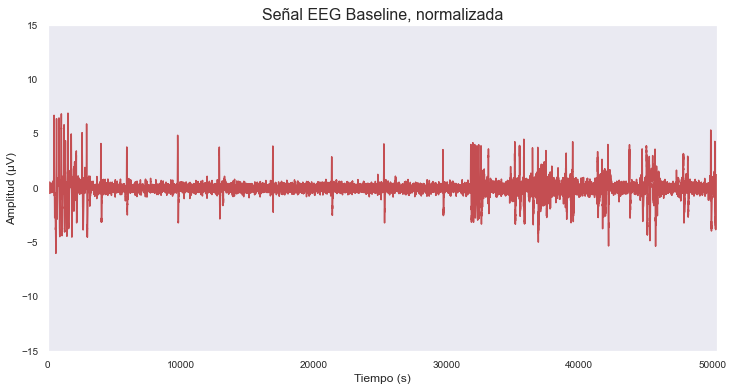

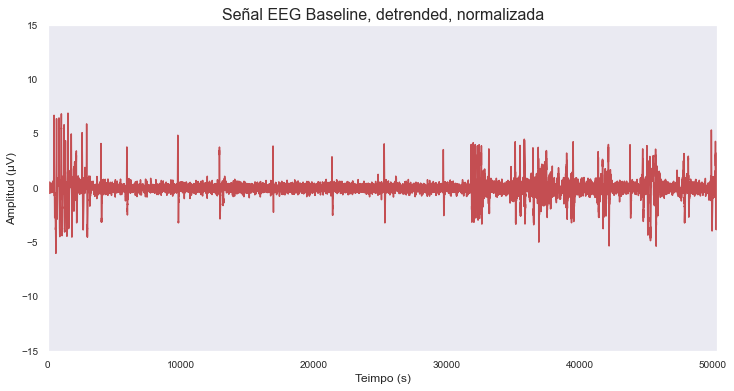

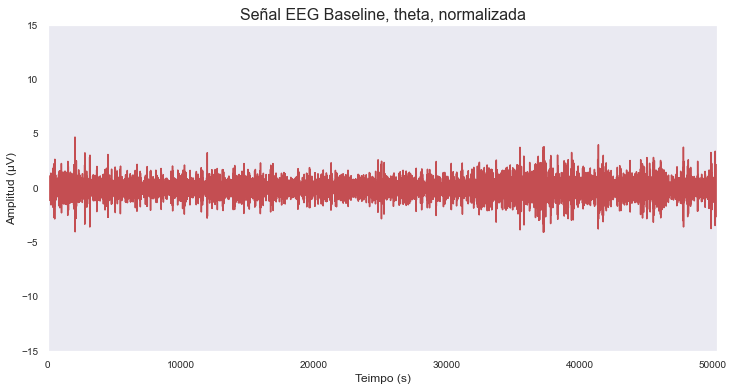

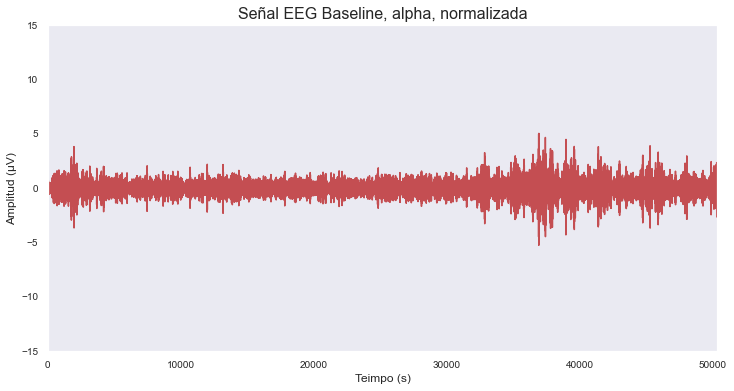

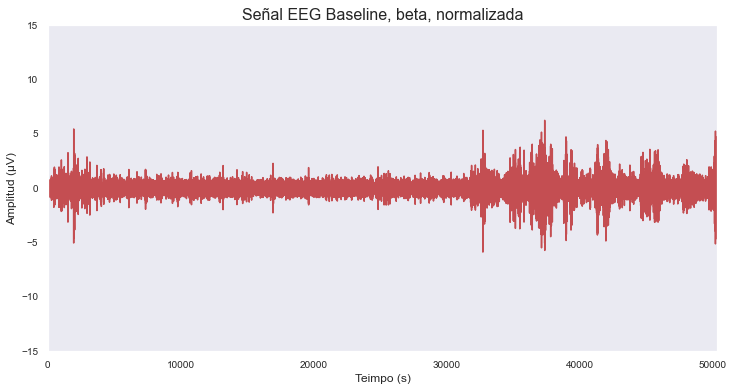

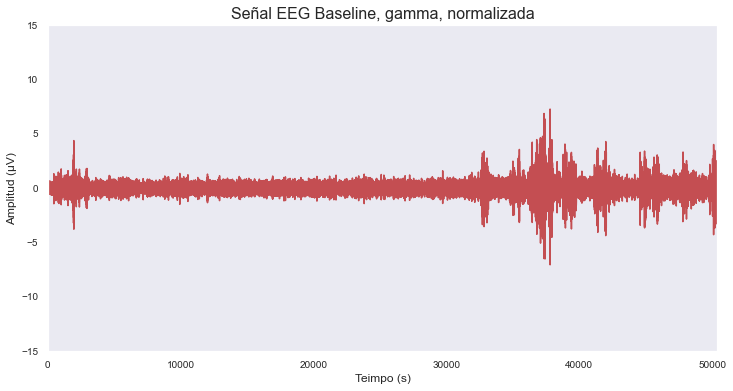

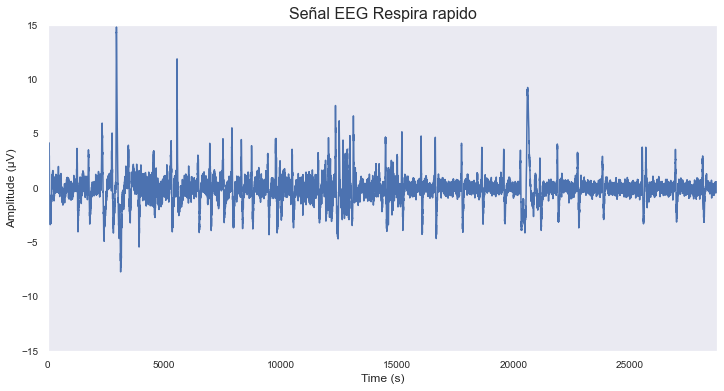

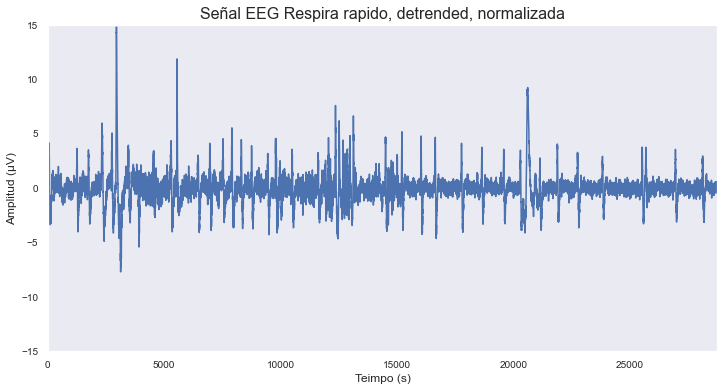

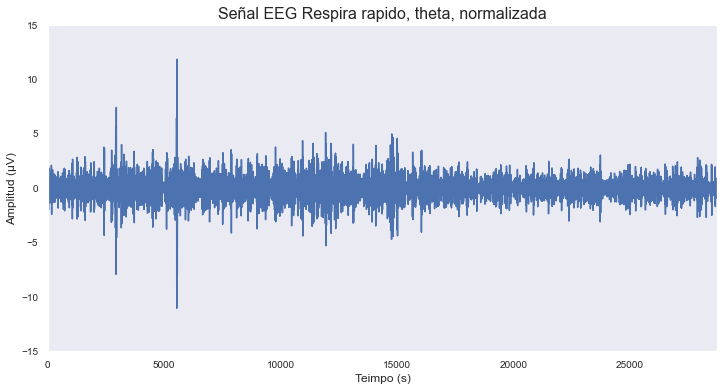

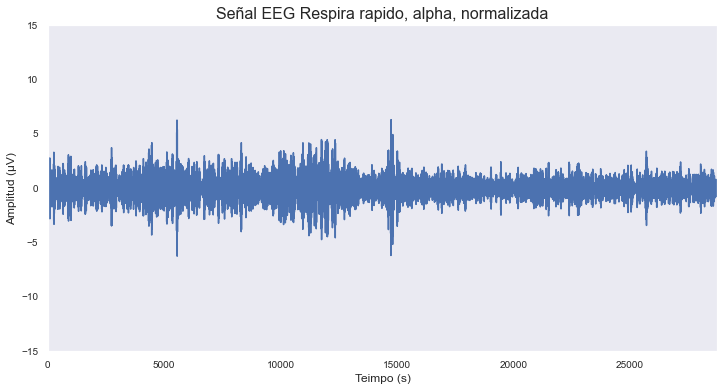

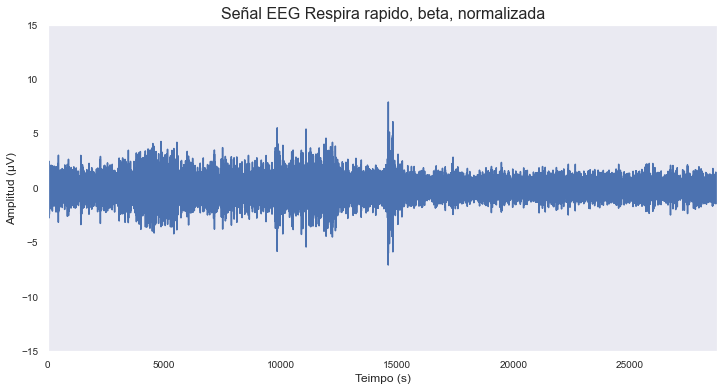

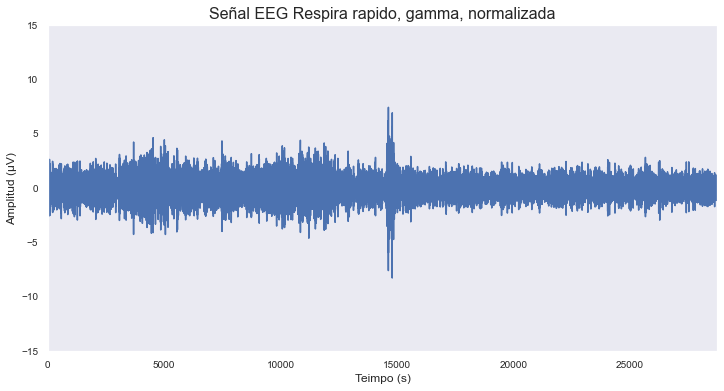

In [29]:
print("Estructura de baseline_resprapido")
print(baseline_resprapido.shape)

baseline = baseline_resprapido[baseline_resprapido['label'] == 'baseline']
baseline_data = baseline.values
baseline_eeg_norm = baseline_data[:,25]

plt.figure(figsize=(12, 6))
plt.plot(baseline_eeg_norm, 'r', label='EEG Signal')
plt.xlabel('Tiempo (s)', fontsize=12);
plt.ylabel('Amplitud (µV)', fontsize=12);
plt.title('Señal EEG Baseline, normalizada', fontsize=16)
plt.ylim([-15, 15]);
plt.xlim([0, len(baseline_eeg)])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

baseline_eeg_detrended_norm = baseline_data[:,26]

plt.figure(figsize=(12, 6))
plt.plot(baseline_eeg_detrended_norm, 'r', label='EEG Signal')
plt.xlabel('Teimpo (s)', fontsize=12);
plt.ylabel('Amplitud (µV)', fontsize=12);
plt.title('Señal EEG Baseline, detrended, normalizada', fontsize=16)
plt.ylim([-15, 15]);
plt.xlim([0, len(baseline_eeg_detrended_norm)])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

baseline_eeg_theta_norm = baseline_data[:,27]

plt.figure(figsize=(12, 6))
plt.plot(baseline_eeg_theta_norm, 'r', label='EEG Signal')
plt.xlabel('Teimpo (s)', fontsize=12);
plt.ylabel('Amplitud (µV)', fontsize=12);
plt.title('Señal EEG Baseline, theta, normalizada', fontsize=16)
plt.ylim([-15, 15]);
plt.xlim([0, len(baseline_eeg_theta_norm)])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

baseline_eeg_alpha_norm = baseline_data[:,28]

plt.figure(figsize=(12, 6))
plt.plot(baseline_eeg_alpha_norm, 'r', label='EEG Signal')
plt.xlabel('Teimpo (s)', fontsize=12);
plt.ylabel('Amplitud (µV)', fontsize=12);
plt.title('Señal EEG Baseline, alpha, normalizada', fontsize=16)
plt.ylim([-15, 15]);
plt.xlim([0, len(baseline_eeg_alpha_norm)])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

baseline_eeg_beta_norm = baseline_data[:,29]

plt.figure(figsize=(12, 6))
plt.plot(baseline_eeg_beta_norm, 'r', label='EEG Signal')
plt.xlabel('Teimpo (s)', fontsize=12);
plt.ylabel('Amplitud (µV)', fontsize=12);
plt.title('Señal EEG Baseline, beta, normalizada', fontsize=16)
plt.ylim([-15, 15]);
plt.xlim([0, len(baseline_eeg_beta_norm)])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

baseline_eeg_gamma = baseline_data[:,30]

plt.figure(figsize=(12, 6))
plt.plot(baseline_eeg_gamma, 'r', label='EEG Signal')
plt.xlabel('Teimpo (s)', fontsize=12);
plt.ylabel('Amplitud (µV)', fontsize=12);
plt.title('Señal EEG Baseline, gamma, normalizada', fontsize=16)
plt.ylim([-15, 15]);
plt.xlim([0, len(baseline_eeg)])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

resprapido = baseline_resprapido[baseline_resprapido['label'] == 'respirarapido']
resprapido_data = resprapido.values
resprapido_eeg_norm = resprapido_data[:,25]

plt.figure(figsize=(12, 6))
plt.plot(resprapido_eeg_norm, 'b', label='EEG Signal')
plt.xlabel('Time (s)', fontsize=12);
plt.ylabel('Amplitude (µV)', fontsize=12);
plt.title('Señal EEG Respira rapido', fontsize=16)
plt.ylim([-15, 15]);
plt.xlim([0, len(resprapido_eeg_norm)])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

resprapido_eeg_detrended_norm = resprapido_data[:,26]

plt.figure(figsize=(12, 6))
plt.plot(resprapido_eeg_detrended_norm, 'b', label='EEG Signal')
plt.xlabel('Teimpo (s)', fontsize=12);
plt.ylabel('Amplitud (µV)', fontsize=12);
plt.title('Señal EEG Respira rapido, detrended, normalizada', fontsize=16)
plt.ylim([-15, 15]);
plt.xlim([0, len(resprapido_eeg_detrended_norm)])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

resprapido_eeg_theta_norm = resprapido_data[:,27]

plt.figure(figsize=(12, 6))
plt.plot(resprapido_eeg_theta_norm, 'b', label='EEG Signal')
plt.xlabel('Teimpo (s)', fontsize=12);
plt.ylabel('Amplitud (µV)', fontsize=12);
plt.title('Señal EEG Respira rapido, theta, normalizada', fontsize=16)
plt.ylim([-15, 15]);
plt.xlim([0, len(resprapido_eeg_theta_norm)])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

resprapido_eeg_alpha_norm = resprapido_data[:,28]

plt.figure(figsize=(12, 6))
plt.plot(resprapido_eeg_alpha_norm, 'b', label='EEG Signal')
plt.xlabel('Teimpo (s)', fontsize=12);
plt.ylabel('Amplitud (µV)', fontsize=12);
plt.title('Señal EEG Respira rapido, alpha, normalizada', fontsize=16)
plt.ylim([-15, 15]);
plt.xlim([0, len(resprapido_eeg_alpha_norm)])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

resprapido_eeg_beta_norm = resprapido_data[:,29]

plt.figure(figsize=(12, 6))
plt.plot(resprapido_eeg_beta_norm, 'b', label='EEG Signal')
plt.xlabel('Teimpo (s)', fontsize=12);
plt.ylabel('Amplitud (µV)', fontsize=12);
plt.title('Señal EEG Respira rapido, beta, normalizada', fontsize=16)
plt.ylim([-15, 15]);
plt.xlim([0, len(resprapido_eeg_beta_norm)])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

resprapido_eeg_gamma_norm = resprapido_data[:,30]

plt.figure(figsize=(12, 6))
plt.plot(resprapido_eeg_gamma_norm, 'b', label='EEG Signal')
plt.xlabel('Teimpo (s)', fontsize=12);
plt.ylabel('Amplitud (µV)', fontsize=12);
plt.title('Señal EEG Respira rapido, gamma, normalizada', fontsize=16)
plt.ylim([-15, 15]);
plt.xlim([0, len(resprapido_eeg_gamma_norm)])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.show()

De acuerdo a la inspección de los gráficos anteriores, los features correspondientes a cada uno de los estados (baseline y respirarapido) muestran grandes diferencias entre sí. Esto nos lleva a emplearlos como regresores en los modelos predictores.

# División de la muestra, generación de modelos y evaluación.

## División de la muestra y recodificación de variable predicha

En primer lugar, dividimos la muestra en dos submuestras: train y test. La primera está compuesta por el 80% de las observaciones, mientras que el restante corresponde a lo utilizado para testeo. A su vez, la variable *y* fue estratificada, lo cual implica que en train y test se mantienen las proporciones entre las dos clases.
La variable a predecir es la categoría relacionable con el estado del sujeto (baseline vs. respirarapido), mientras que las variables regresoras son la señal *eeg*, y las bandas theta, alfa, beta y gamma.

In [31]:
from sklearn.model_selection import train_test_split

# Seleccionamos datos y features incluidos en los modelos
regresores = baseline_resprapido[['eeg_normalized', 'eeg_theta_normalized', 'eeg_alpha_normalized','eeg_beta_normalized','eeg_gamma_normalized']]
y = baseline_resprapido['label']

#Dividimos la muestra en train y test, asignando un 20% a la segunda parte
regresores_train, regresores_test, y_train, y_test = train_test_split(regresores, y, test_size=0.2, random_state=0, stratify=y)

print("Dimensiones del Train set (%d,%d)" % regresores_train.shape)
print("Dimensiones del Test set (%d,%d)" % regresores_test.shape)

#Codificamos las etiquetas de la variable regresada para que sean 0 y 1
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

Dimensiones del Train set (63288,5)
Dimensiones del Test set (15823,5)


## Entrenamiento y fiteo de modelos

Posteriormente, se generaron una serie de modelos cuyo objetivo es predecir la variable binaria categoría (respirarapido=0; baseline=1). Las técnicas que se tuvieron en cuenta son:

1. Regresión logística (*Logistic Regression*)
2. Árboles de decisión (*Decision Tree*)
3. Support Vector Machine (*SVM*) Lineal (*Linear*)
4. Support Vector Machine (*SVM*) Polinómico (*Polynomic*)
5. Support Vector Machine (*SVM*) Radial Basis Function (*RBF*)
6. K-neighbors (*KN*)
7. Random Forest (*Random Forest*)
8. Linear Discriminant Analysis (*LDAF*)
9. Redes Neuronales (*Neural Networks*)

En todos los casos se utilizó la semilla **0**.
En el caso de la Red Neuronal, se emplearon 600 iteraciones. En tanto, para el Random Forest se seleccionaron 100 estimadores y para el k-neighbors, 5 vecinos. Finalmente, todos los demás modelos se dejaron en su versión *default*.

In [33]:
# Entrenamos los modelos
t0 = time()
log_reg = LogisticRegression(random_state=0)
t1 = time()
print('Tiempo que tarda en generar el modelo Log Reg: {} s'.format(round(t1-t0,2)))

t0 = time()
dec_tree = DecisionTreeClassifier(random_state=0)
t1 = time()
print('Tiempo que tarda en generar el modelo Decision Tree: {} s'.format(round(t1-t0,2)))

#t0 = time()
#svm_lin = SVC(kernel='linear', random_state=0)
#t1 = time()
#print('Tiempo que tarda en generar el modelo SVM lineal: {} s'.format(round(t1-t0,2)))

t0 = time()
svm_pol = SVC(kernel='poly', random_state=0)
t1 = time()
print('Tiempo que tarda en generar el modelo SVM Polinómico: {} s'.format(round(t1-t0,2)))

t0 = time()
svm_rbf = SVC(kernel='rbf', random_state=0)
t1 = time()
print('Tiempo que tarda en generar el modelo SVM RBF: {} s'.format(round(t1-t0,2)))

t0 = time()
kn = KNeighborsClassifier(n_neighbors=5)
t1 = time()
print('Tiempo que tarda en generar el modelo KN: {} s'.format(round(t1-t0,2)))

t0 = time()
rf = RandomForestClassifier(n_estimators=100, random_state=0)
t1 = time()
print('Tiempo que tarda en generar el modelo Random Forest: {} s'.format(round(t1-t0,2)))

t0 = time()
ldaf = LinearDiscriminantAnalysis()
t1 = time()
print('Tiempo que tarda en generar el modelo LDAF: {} s'.format(round(t1-t0,2)))

t0 = time()
nn = MLPClassifier(max_iter=600, random_state=0)
t1 = time()
print('Tiempo que tarda en generar el modelo Neural Networks: {} s'.format(round(t1-t0,2)))

# Construimos los modelos a partir de "fit"
t0 = time()
log_reg.fit(regresores_train, y_train)
t1 = time()
print('Tiempo que tarda en generar el fit del modelo LOG REG: {} s'.format(round(t1-t0,2)))

t0 = time()
dec_tree.fit(regresores_train, y_train)
t1 = time()
print('Tiempo que tarda en generar el fit del modelo DEC TREE: {} s'.format(round(t1-t0,2)))

#t0 = time()
#svm_lin.fit(regresores_train,, y_train)
#t1 = time()
#print('Tiempo que tarda en generar el fitear el modelo SVM LIN: {} s'.format(round(t1-t0,2)))

t0 = time()
svm_pol.fit(regresores_train, y_train)
t1 = time()
print('Tiempo que tarda en generar el fit del modelo SVM POL: {} s'.format(round(t1-t0,2)))

t0 = time()
svm_rbf.fit(regresores_train, y_train)
t1 = time()
print('Tiempo que tarda en generar el fit del modelo SVM RBF: {} s'.format(round(t1-t0,2)))

t0 = time()
kn.fit(regresores_train, y_train)
t1 = time()
print('Tiempo que tarda en generar el fit del modelo SVM KN: {} s'.format(round(t1-t0,2)))

t0 = time()
rf.fit(regresores_train, y_train)
t1 = time()
print('Tiempo que tarda en generar el fit del modelo Random Forest: {} s'.format(round(t1-t0,2)))

t0 = time()
ldaf.fit(regresores_train, y_train)
t1 = time()
print('Tiempo que tarda en generar el fit del modelo LDAF: {} s'.format(round(t1-t0,2)))

t0 = time()
nn.fit(regresores_train, y_train)
t1 = time()
print('Tiempo que tarda en generar el fit del modelo Neural Networks: {} s'.format(round(t1-t0,2)))

Tiempo que tarda en generar el modelo Log Reg: 0.0 s
Tiempo que tarda en generar el modelo Decision Tree: 0.0 s
Tiempo que tarda en generar el modelo SVM Polinómico: 0.0 s
Tiempo que tarda en generar el modelo SVM RBF: 0.0 s
Tiempo que tarda en generar el modelo KN: 0.0 s
Tiempo que tarda en generar el modelo Random Forest: 0.0 s
Tiempo que tarda en generar el modelo LDAF: 0.0 s
Tiempo que tarda en generar el modelo Neural Networks: 0.0 s
Tiempo que tarda en generar el fit del modelo LOG REG: 0.03 s
Tiempo que tarda en generar el fit del modelo DEC TREE: 0.51 s
Tiempo que tarda en generar el fit del modelo SVM POL: 3666.0 s
Tiempo que tarda en generar el fit del modelo SVM RBF: 99.5 s
Tiempo que tarda en generar el fit del modelo SVM RBF: 0.08 s
Tiempo que tarda en generar el fit del modelo Random Forest: 12.11 s
Tiempo que tarda en generar el fit del modelo LDAF: 0.03 s
Tiempo que tarda en generar el fit del modelo Neural Networks: 19.77 s


In [52]:
#Modelo SVM lineal
t0 = time()
svm_lin = SVC(kernel='linear', random_state=0)
t1 = time()
print('Tiempo que tarda en generar el modelo SVM lineal: {} s'.format(round(t1-t0,2)))

t0 = time()
svm_lin.fit(regresores_train, y_train)
t1 = time()
print('Tiempo que tarda en generar el fitear el modelo SVM LIN: {} s'.format(round(t1-t0,2)))

Tiempo que tarda en generar el modelo SVM lineal: 0.0 s
Tiempo que tarda en generar el fitear el modelo SVM LIN: 112.33 s


In [53]:
#Obtenemos los resultados predichos
t0 = time()
y_pred_log_reg = log_reg.predict(regresores_test)
t1 = time()
print('Tiempo que tarda LOG REG en generar predicciones: {} s'.format(round(t1-t0,2)))

t0 = time()
y_pred_dec_tree = dec_tree.predict(regresores_test)
t1 = time()
print('Tiempo que tarda DEC TREE en generar predicciones: {} s'.format(round(t1-t0,2)))

t0 = time()
y_pred_svm_lin = svm_lin.predict(regresores_test)
t1 = time()
print('Tiempo que tarda SVM LIN en generar predicciones: {} s'.format(round(t1-t0,2)))

t0 = time()
y_pred_svm_pol = svm_pol.predict(regresores_test)
t1 = time()
print('Tiempo que tarda SVM POL en generar predicciones: {} s'.format(round(t1-t0,2)))

t0 = time()
y_pred_svm_rbf = svm_rbf.predict(regresores_test)
t1 = time()
print('Tiempo que tarda SVM RBF en generar predicciones: {} s'.format(round(t1-t0,2)))

t0 = time()
y_pred_kn = kn.predict(regresores_test)
t1 = time()
print('Tiempo que tarda KN en generar predicciones: {} s'.format(round(t1-t0,2)))

t0 = time()
y_pred_rf = rf.predict(regresores_test)
t1 = time()
print('Tiempo que tarda Random Forest en generar predicciones: {} s'.format(round(t1-t0,2)))

t0 = time()
y_pred_ldaf = kn.predict(regresores_test)
t1 = time()
print('Tiempo que tarda Linear Discriminant Analysis en generar predicciones: {} s'.format(round(t1-t0,2)))

t0 = time()
y_pred_nn = nn.predict(regresores_test)
t1 = time()
print('Tiempo que tarda Neural Networks en generar predicciones: {} s'.format(round(t1-t0,2)))

Tiempo que tarda LOG REG en generar predicciones: 0.0 s
Tiempo que tarda DEC TREE en generar predicciones: 0.01 s
Tiempo que tarda SVM LIN en generar predicciones: 13.4 s
Tiempo que tarda SVM POL en generar predicciones: 14.02 s
Tiempo que tarda SVM RBF en generar predicciones: 45.71 s
Tiempo que tarda KN en generar predicciones: 0.51 s
Tiempo que tarda Random Forest en generar predicciones: 0.31 s
Tiempo que tarda Linear Discriminant Analysis en generar predicciones: 0.53 s
Tiempo que tarda Neural Networks en generar predicciones: 0.0 s


## Evaluación de predicciones

Luego, evaluamos la capacidad predictiva de las predicciones a partir de 3 criterios principales:

1. Accuracy
2. Curvas ROC (*Receiver Operating Characteristic*)
3. Matrices de confusión

La primera de las tres técnicas (**accuracy**) es una medida resumen de la proporción de predicciones categorizadas correctamente (cociente entre la suma de los verdadero positivo y verdadero negativo, y por otro lado, el total de predicciones). \
En tanto, las **curvas ROC** dan cuenta de la tasa de verdaderos positivos (ratio verdaderos positivos/total de verdaderos), graficados en el eje *y*, frente a la proporción de falsos positivos (ratio falsos positivos/(falsos positivos+verdaderos negativos)), presentados en el eje *x*. En otras palabras, permiten tener una noción visual de la relación entre sensibilidad y el complemento de la especificidad. De esta forma, el modelo con mejor desempeño en los términos señalados sería graficado como una curva cuyos vértices se encuentran en las coordenadas (0,0), (1,0) y (1,1), logrando la mayor tasa de verdaderos positivos y la menor tasa de falsos positivos. En tanto, un modelo con desempeño promedio pasaría por la línea de 45°, equivalente a un ejercicio de tirado de una moneda sin carga (azar).\
Finalmente, **las matrices de confusión** distribuyen las predicciones en 4 cuadrantes: verdaderos positivos (superior izquierda), falsos positivos (superior derecha), falsos negativos (inferior izquierda) y verdaderos negativos (inferior derecha). De esta forma, permite desagregar tanto la medida de *accuracy* (entendida como el cociente entre la suma de la diagonal de la matriz y la suma de todas las celdas) como la curva ROC. Esta última expone, en términos de la matriz de confusión, en el eje *y* el cociente entre el valor de la celda superior izquierda (verdadero positivo) y la suma de las celdas de la primera columna (verdadero); mientras que en el eje *x* exhibe el ratio entre el valor del cuadrante superior derecho (falso positivo) y la suma de los valores de la segunda columna (negativo).

In [56]:
print("Accuracy LOG_REG:", round(accuracy_score(y_test, y_pred_log_reg),3))
print("Accuracy DEC_TREE:", round(accuracy_score(y_test, y_pred_dec_tree),3))
print("Accuracy SVM_LIN:", round(accuracy_score(y_test, y_pred_svm_lin),3))
print("Accuracy SVM_POL:", round(accuracy_score(y_test, y_pred_svm_pol),3))
print("Accuracy SVM_RBF:", round(accuracy_score(y_test, y_pred_svm_rbf),3))
print("Accuracy KN:", round(accuracy_score(y_test, y_pred_kn),3))
print("Accuracy RF:", round(accuracy_score(y_test, y_pred_rf),3))
print("Accuracy LDAF:", round(accuracy_score(y_test, y_pred_ldaf),3))
print("Accuracy NN:", round(accuracy_score(y_test, y_pred_nn),3))

Accuracy LOG_REG: 0.636
Accuracy DEC_TREE: 0.653
Accuracy SVM_LIN: 0.636
Accuracy SVM_POL: 0.638
Accuracy SVM_RBF: 0.734
Accuracy KN: 0.716
Accuracy RF: 0.734
Accuracy LDAF: 0.716
Accuracy NN: 0.735


In [57]:
# Matrices de confusión
mc_log_reg = confusion_matrix(y_test, y_pred_log_reg)
mc_dec_tree = confusion_matrix(y_test, y_pred_dec_tree)
mc_svm_lin = confusion_matrix(y_test, y_pred_svm_lin)
mc_svm_pol = confusion_matrix(y_test, y_pred_svm_pol)
mc_svm_rbf = confusion_matrix(y_test, y_pred_svm_rbf)
mc_kn = confusion_matrix(y_test, y_pred_kn)
mc_rf = confusion_matrix(y_test, y_pred_rf)
mc_ldaf = confusion_matrix(y_test, y_pred_ldaf)
mc_nn = confusion_matrix(y_test, y_pred_nn)

print("Matriz de confusión LOG_REG:\n", mc_log_reg)
print("Matriz de confusión DEC_TREE:\n", mc_dec_tree)
print("Matriz de confusión SVM_LIN:\n", mc_svm_lin)
print("Matriz de confusión SVM_POL:\n", mc_svm_pol)
print("Matriz de confusión SVM_RBF:\n", mc_svm_rbf)
print("Matriz de confusión KN:\n", mc_kn)
print("Matriz de confusión RF:\n", mc_rf)
print("Matriz de confusión LDAF:\n", mc_ldaf)
print("Matriz de confusión NN:\n", mc_nn)

Matriz de confusión LOG_REG:
 [[10071     0]
 [ 5752     0]]
Matriz de confusión DEC_TREE:
 [[7307 2764]
 [2719 3033]]
Matriz de confusión SVM_LIN:
 [[10071     0]
 [ 5752     0]]
Matriz de confusión SVM_POL:
 [[10071     0]
 [ 5728    24]]
Matriz de confusión SVM_RBF:
 [[8642 1429]
 [2783 2969]]
Matriz de confusión KN:
 [[8224 1847]
 [2652 3100]]
Matriz de confusión RF:
 [[8161 1910]
 [2301 3451]]
Matriz de confusión LDAF:
 [[8224 1847]
 [2652 3100]]
Matriz de confusión NN:
 [[8275 1796]
 [2395 3357]]


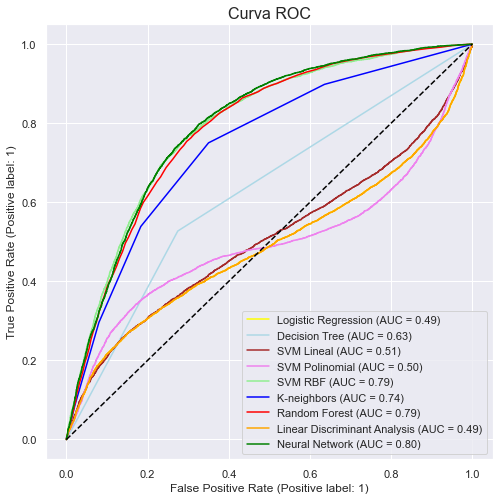

Tiempo que tarda en generar curva ROC: 77.42 s


In [75]:
# Curvas ROC
t0 = time()
fig, ax = plt.subplots(figsize=(8, 8))
plot_roc_curve(log_reg, regresores_test, y_test, color='yellow', name='Logistic Regression', ax=ax)
plot_roc_curve(dec_tree, regresores_test, y_test, color='lightblue', name='Decision Tree', ax=ax)
plot_roc_curve(svm_lin, regresores_test, y_test, color='brown', name='SVM Lineal', ax=ax)
plot_roc_curve(svm_pol, regresores_test, y_test, color='violet', name='SVM Polinomial', ax=ax)
plot_roc_curve(svm_rbf, regresores_test, y_test, color='lightgreen', name='SVM RBF', ax=ax)
plot_roc_curve(kn, regresores_test, y_test, color='blue', name='K-neighbors', ax=ax)
plot_roc_curve(rf, regresores_test, y_test, color='red', name='Random Forest', ax=ax)
plot_roc_curve(ldaf, regresores_test, y_test, color='orange', name='Linear Discriminant Analysis', ax=ax)
plot_roc_curve(nn, regresores_test, y_test, color='green', name='Neural Network', ax=ax)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Curva ROC', fontsize=16)
plt.show()

t1 = time()
print('Tiempo que tarda en generar curva ROC: {} s'.format(round(t1-t0,2)))

Como se desprende de los resultados anteriores, los modelos **SVM Radial Basis Function (*RBF*)**, **Random Forest** y de **Redes Neuronales** son los de mejor desempeño general (mayor *accuracy*, ubicado alrededor de 74%). En el extremo opuesto se ubican los modelos de **regresión logística**, **árbol de decisión**, **SVM lineal** y **SVM polinómico**, con una peor *performance* relativa (en torno al 65% de predicciones correctas). En tanto, en un escalón intermedio se encuentran los modelos de **k-neighboor** y **Linear Discriminant Analysis** (con *accuracies* en torno a 72%). \
Esta situación es apreciable en las curvas ROC, donde las figuras trazadas por el SVM RBF (en verde claro), Random Forest (en rojo) y Neural Network (en verde oscuro) -  muy cercanas entre sí- se encuentran casi constantemente por encima de los demás modelos, dejando así un espacio ROC más elevado y un mejor ratio entre la tasa de verdaderos positivos (eje *y*) y la de falsos positivos (eje *x*). Esta características se aprecia en el valor del área debajo de la curva (**AUC**), que toma un valor en torno a 0,8 para los tres modelos mencionados, superando así al resto.
A su vez, de las matrices de confusión surge que la mejor *performance* de los primeros tres casos se debe especialmente a que pudieron detectar correctamente los casos negativos (asociados con respirarapido), objetivo que no logran realizar eficientemente los otros modelos. Esta particularidad se aprecia en un valor más elevado de las celdas inferior derecha con respecto a la suma de la segunda columna. \
Finalmente, cabe destacar que el trabajo realizado cuenta con ciertas limitaciones y podría ser mejorado con ciertas extensiones. Por un lado, se podrían incorporar filtros adicionales de la señal (como los de convolusión), de forma tal que puedan limpiar incluso más ruido presente en la serie. También podrían usarse otros features útiles, como los rezagos, ventanas móviles, o PSD. Adicionalmente, podría realizarse cross-validation sobre el train, y optimizarse los hiperparémtros de ciertos modelos. Finalmente, podrían generse predicciones que combinen los modelos utilizados.

# Referencias
D’Agostino, R. B. (1971), “An omnibus test of normality for moderate and large sample size”, Biometrika, 58, 341-348. \
D’Agostino, R. y E. S. Pearson (1973), “Tests for departure from normality”, Biometrika, 60, 613-622.